In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.8.8
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.22.4
import numpy as np

# pandas  1.2.4
import pandas as pd

# scikit-learn  0.24.1
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# matplotlib  3.3.4
import matplotlib.pyplot as plt

# load utility classes/functions e.g., plot_decision_regions()
import urllib.request
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/lab04lib.py", "lab04lib.py")
from lab04lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
cd Desktop/ml/labs/08_CV_Ensembling/

/Users/user/Desktop/ml/labs/08_CV_Ensembling


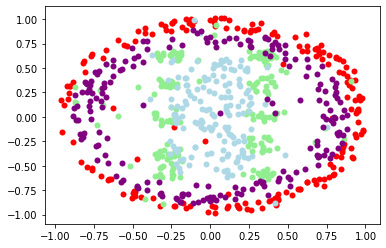

In [4]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_train = np.ndarray((0, 2))
y_train = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X_train = np.vstack((X_train, np.array(row[0:2])))
    y_train = np.append(y_train, y_mapping[row[2]])
X_train = X_train.astype(np.float)
y_train = y_train.astype(np.float)
file.close()

plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_train[y_train == 2, 0], X_train[y_train == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1], label='Sue', c='purple', linewidths=0)

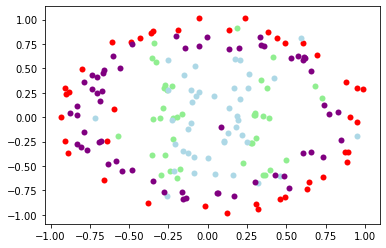

In [5]:
file = open('./test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_test = np.ndarray((0, 2))
y_test = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X_test = np.vstack((X_test, np.array(row[0:2])))
    y_test = np.append(y_test, y_mapping[row[2]])
X_test = X_test.astype(np.float)
y_test = y_test.astype(np.float)
file.close()

plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_test[y_test == 2, 0], X_test[y_test == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_test[y_test == 3, 0], X_test[y_test == 3, 1], label='Sue', c='purple', linewidths=0)

# Your code and accuracy by all the models you have tried, which will at least include voting, bagging, and boosting models

## SVC

In [17]:
from sklearn.svm import SVC
print('[Grid Search for SVC\'s hyperparameter]')
param_C = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

svm = SVC(random_state=0)

param_grid = [{'C': param_C, 
               'gamma': param_gamma, 
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy')
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

[Grid Search for SVC's hyperparameter]
0.8631457988600845
{'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}


## SVM, DecisionTree, KNN, Logistic Regression CV=10

In [18]:
print('[SVM, DecisionTree, KNN, Logistic Regression CV]')
clf_labels = ['SVC', 'DecisionTree', 'KNN', 'LogisticRegression']

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', SVC(kernel='rbf', random_state=0, gamma=1.0, C=1000.0, probability=True)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 10, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])
pipe4 = Pipeline([['sc', StandardScaler()],['clf', LogisticRegression(solver='lbfgs', max_iter = 2000)]])

for pipe, label in zip([pipe1, pipe2, pipe3, pipe4], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[SVM, DecisionTree, KNN, Logistic Regression CV]
SVC: 0.862 (+/- 0.059)
DecisionTree: 0.772 (+/- 0.071)
KNN: 0.821 (+/- 0.053)
LogisticRegression: 0.278 (+/- 0.038)


### Testing

In [30]:
pipe1.fit(X_train,y_train)
y_pred = pipe1.predict(X_test)
print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))


Testing Accuracy: 0.832


## Logistic Regression (Poly)

In [19]:
print('[Grid Search For The Best Poly Degree For LogisticRegression]')
degrees = [2,3,4,5,6,7,8,9,10,11,12,13,14]

for degree in degrees:
    poly = PolynomialFeatures(degree = degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    scores = cross_val_score(estimator=pipe4, X=X_train_poly, y=y_train, cv=10, scoring='accuracy')
    print('Degree %d: %.3f (+/- %.3f)' % (degree, scores.mean(), scores.std()))

[Grid Search For The Best Poly Degree For LogisticRegression]
Degree 2: 0.836 (+/- 0.035)
Degree 3: 0.828 (+/- 0.052)
Degree 4: 0.844 (+/- 0.047)
Degree 5: 0.836 (+/- 0.048)
Degree 6: 0.846 (+/- 0.053)
Degree 7: 0.839 (+/- 0.051)
Degree 8: 0.850 (+/- 0.055)
Degree 9: 0.851 (+/- 0.058)
Degree 10: 0.855 (+/- 0.059)
Degree 11: 0.859 (+/- 0.056)
Degree 12: 0.862 (+/- 0.056)
Degree 13: 0.858 (+/- 0.057)
Degree 14: 0.858 (+/- 0.057)


In [20]:
for degree in degrees:
    print('[LogisticRegression degree = '+ str(degree)+' Testing ]')
    pipe4 = Pipeline([['sc', StandardScaler()],['poly', PolynomialFeatures(degree = degree)],
                  ['clf', LogisticRegression(solver='lbfgs', max_iter = 4000)]])
    pipe4.fit(X_train,y_train)
    y_pred = pipe4.predict(X_test)
    print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[LogisticRegression degree = 2 Testing ]

Testing Accuracy: 0.789
[LogisticRegression degree = 3 Testing ]

Testing Accuracy: 0.800
[LogisticRegression degree = 4 Testing ]

Testing Accuracy: 0.822
[LogisticRegression degree = 5 Testing ]

Testing Accuracy: 0.795
[LogisticRegression degree = 6 Testing ]

Testing Accuracy: 0.827
[LogisticRegression degree = 7 Testing ]

Testing Accuracy: 0.816
[LogisticRegression degree = 8 Testing ]

Testing Accuracy: 0.822
[LogisticRegression degree = 9 Testing ]

Testing Accuracy: 0.816
[LogisticRegression degree = 10 Testing ]

Testing Accuracy: 0.832
[LogisticRegression degree = 11 Testing ]

Testing Accuracy: 0.822
[LogisticRegression degree = 12 Testing ]

Testing Accuracy: 0.816
[LogisticRegression degree = 13 Testing ]

Testing Accuracy: 0.805
[LogisticRegression degree = 14 Testing ]

Testing Accuracy: 0.789


## Soft Voting

In [25]:
print('[Voting CV]')
poly_grid = [2,5,7]
best_poly = 0
best_vt, best_w, best_score = None, (), -1
for poly in poly_grid:
    for a, b, c, d in list(itertools.permutations(range(0,4))):
        pipe4 = Pipeline([['sc', StandardScaler()],['poly', PolynomialFeatures(degree = poly)],
                      ['clf', LogisticRegression(solver='lbfgs', max_iter = 500)]])
        clf = VotingClassifier(estimators=[('svc', pipe1), ('dt', pipe2), ('knn', pipe3), ('lr',pipe4)], 
                               voting='soft', weights=[a,b,c,d])
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
        if best_score < scores.mean():
            best_vt, best_w, best_score = clf, (a, b, c, d), scores.mean()
            best_poly = poly

print('\nWith logistic regression degree = %d Best %s: %.3f' % (best_poly,best_w, best_score))

[Voting CV]

With logistic regression degree = 2 Best (3, 0, 1, 2): 0.881


### Testing

In [27]:
best_vt.fit(X_train,y_train)

y_pred = best_vt.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))


Testing Accuracy: 0.838


## Hard Voting

In [28]:
print('[Voting CV]')
pipe4 = Pipeline([['sc', StandardScaler()],['poly', PolynomialFeatures(degree = best_poly)],
                      ['clf', LogisticRegression(solver='lbfgs', max_iter = 200)]])
clf = VotingClassifier(estimators=[('svc', pipe1), ('dt', pipe2), ('knn', pipe3), ('lr',pipe4)], 
                           voting='hard')
scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
print('%.3f (+/- %.3f)' % (scores.mean(), scores.std()))

[Voting CV]
0.858 (+/- 0.060)


### Testing

In [29]:
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))


Testing Accuracy: 0.816


## Bagging (Decision Tree)

In [31]:
print('[Bagging of tree CV]')
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

scores = cross_val_score(estimator=bag, X=X_train, y=y_train, cv=10, scoring='accuracy')
print('%.3f (+/- %.3f)' % (scores.mean(), scores.std()))

[Bagging of tree CV]
0.827 (+/- 0.044)


### Testing

In [32]:
bag = bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

print('Testing Accuracy: %.3f' % accuracy_score(y_test, y_pred) )

Testing Accuracy: 0.811


# Use Gridsearch to fine-tune your results. In particular, for base learner of adaboost, we hope you can try decision stump (decision tree with depth 1) and decision tree with higher depths

## AdaBoost (Decision Tree)

In [34]:
print('[AdaBoost of tree CV]')

best_depth, best_score = -1, -1
depth_grid = []
depth_grid.extend(range(3,20))

for depth in depth_grid:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
    scores = cross_val_score(ada, X_train, y_train, cv=5)
    print('[Tree depth = %d]\nValidation accuracy: %.3f' % (depth, scores.mean()))
    if scores.mean() > best_score:
        best_depth, best_score = depth, scores.mean()

[AdaBoost of tree CV]
[Tree depth = 3]
Validation accuracy: 0.751
[Tree depth = 4]
Validation accuracy: 0.789
[Tree depth = 5]
Validation accuracy: 0.806
[Tree depth = 6]
Validation accuracy: 0.820
[Tree depth = 7]
Validation accuracy: 0.820
[Tree depth = 8]
Validation accuracy: 0.827
[Tree depth = 9]
Validation accuracy: 0.827
[Tree depth = 10]
Validation accuracy: 0.825
[Tree depth = 11]
Validation accuracy: 0.827
[Tree depth = 12]
Validation accuracy: 0.809
[Tree depth = 13]
Validation accuracy: 0.778
[Tree depth = 14]
Validation accuracy: 0.787
[Tree depth = 15]
Validation accuracy: 0.767
[Tree depth = 16]
Validation accuracy: 0.764
[Tree depth = 17]
Validation accuracy: 0.756
[Tree depth = 18]
Validation accuracy: 0.756
[Tree depth = 19]
Validation accuracy: 0.760


### Testing

In [35]:
print('[AdaBoost of tree, tree depth = %d]' % best_depth)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, random_state=0)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print('Testing accuracy %.3f' % accuracy_score(y_test, y_pred))

[AdaBoost of tree, tree depth = 9]
Testing accuracy 0.811


## Soft Voting (AdaBoost tree + KNN)

In [49]:
best_vt, best_score = None, -1
for a, b in list(itertools.permutations(range(1,3))):
    clf = VotingClassifier(estimators=[('Ada', ada),('knn', pipe3)], 
                           voting='soft', weights=[a,b])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt = clf

(1, 2): 0.847 (+/- 0.044)
(2, 1): 0.825 (+/- 0.046)


### Testing

In [50]:
best_vt.fit(X_train,y_train)

y_pred = best_vt.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))


Testing Accuracy: 0.816


## Hard Voting (AdaBoost tree + KNN)

In [38]:
clf = VotingClassifier(estimators=[('Ada', ada),('knn', pipe3)], 
                           voting='hard')
scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
print('%.3f (+/- %.3f)' % (scores.mean(), scores.std()))

0.814 (+/- 0.053)


### Testing

In [39]:
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))


Testing Accuracy: 0.778


## Soft Voting (Bagging tree + KNN)

In [47]:
best_vt, best_score = None, -1
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
for a, b in list(itertools.permutations(range(1,3))):
    clf = VotingClassifier(estimators=[('bag', bag),('knn', pipe3)], 
                           voting='soft', weights=[a,b])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt = clf

(1, 2): 0.847 (+/- 0.054)
(2, 1): 0.847 (+/- 0.044)


### Testing

In [48]:
best_vt.fit(X_train,y_train)

y_pred = best_vt.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))


Testing Accuracy: 0.805


## Soft Voting (SVM + AdaBoost tree + Bagging tree + KNN)

In [45]:
best_vt, best_score = None, -1
tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
for a, b, c, d in list(itertools.permutations(range(0,4))):
    clf = VotingClassifier(estimators=[('svc', pipe1),('Ada', ada),('bag', bag),('knn', pipe3)], 
                           voting='soft', weights=[a,b,c,d])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c,d), scores.mean(), scores.std()))
    if best_score < scores.mean():
            best_vt, best_w, best_score = clf, (a, b, c, d), scores.mean()
            best_poly = poly

(0, 1, 2, 3): 0.855 (+/- 0.042)
(0, 1, 3, 2): 0.856 (+/- 0.044)
(0, 2, 1, 3): 0.846 (+/- 0.039)
(0, 2, 3, 1): 0.835 (+/- 0.043)
(0, 3, 1, 2): 0.839 (+/- 0.042)
(0, 3, 2, 1): 0.835 (+/- 0.051)
(1, 0, 2, 3): 0.859 (+/- 0.042)
(1, 0, 3, 2): 0.852 (+/- 0.046)
(1, 2, 0, 3): 0.846 (+/- 0.045)
(1, 2, 3, 0): 0.840 (+/- 0.045)
(1, 3, 0, 2): 0.837 (+/- 0.049)
(1, 3, 2, 0): 0.839 (+/- 0.047)
(2, 0, 1, 3): 0.865 (+/- 0.049)
(2, 0, 3, 1): 0.859 (+/- 0.040)
(2, 1, 0, 3): 0.860 (+/- 0.044)
(2, 1, 3, 0): 0.856 (+/- 0.044)
(2, 3, 0, 1): 0.842 (+/- 0.045)
(2, 3, 1, 0): 0.840 (+/- 0.045)
(3, 0, 1, 2): 0.874 (+/- 0.048)
(3, 0, 2, 1): 0.867 (+/- 0.044)
(3, 1, 0, 2): 0.871 (+/- 0.051)
(3, 1, 2, 0): 0.863 (+/- 0.045)
(3, 2, 0, 1): 0.850 (+/- 0.051)
(3, 2, 1, 0): 0.850 (+/- 0.052)


### Testing

In [46]:
best_vt.fit(X_train,y_train)

y_pred = best_vt.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))


Testing Accuracy: 0.843


# Try to evaluate and summarize the results

For tuning the hyperparameter, I use grid search and cross validation (CV). The best model is the soft voting which combines the SVMClassifier, Bagging of tree and KNeighborsClassifier. The testing acc of the best model is 0.84.